# Flat Clustering (K-Means)
---
**Learning notes**
- K-means works on minimizing the Variance of the clusters. Therefore, it works son Euclidean distances to the center. 
- The basic idea of k-means is to minimize squared errors. There is no "distance" involved here.   
    Why it is not correct to use arbitary distances: because k-means may stop converging with other distance functions. 
- However, normalized vectors keep a linear relationship between Euclidean Distance and their Cosine. Norm = 2(1-cos())  
  
**K-Medoids**  
- Alternative to K-Means. The medoid is the existing object most central to the cluster. Only needs the pairwise distances.
- It is more robust to noise and outliers because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances.
- A medoid can be defined as the object of a cluster whose average dissimilarity to all the objects in the cluster is minimal, that is, it is a most centrally located point in the cluster.  
  
**Kernel k-Means**  
When you cannot represent a data point as a Euclidean vector, but if you can still calculate (or define) the inner product between two data points then you can kernelize the algorithm
- Alternative to K-Means. The calculation of distance, kernel method is used instead of the Euclidean distance.
- Algorithm is able to identify the non-linear structures.

## Env Preparation

In [1]:
import os
import sys
#os.chdir('/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering')
os.chdir('/home/jovyan/work/')
print(os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

/home/jovyan/work


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data Preparation

In [ ]:
print(data.category.value_counts())
data.category.hist()

In [17]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l.split(' ')))
data.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,806
1,business,worldcom boss left books alone former worldc...,332
2,sport,tigers wary of farrell gamble leicester say ...,270
3,sport,yeading face newcastle in fa cup premiership s...,390
4,entertainment,ocean s twelve raids box office ocean s twelve...,287


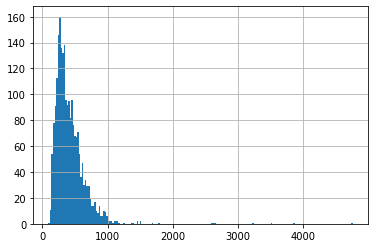

In [32]:
data['lenght'].hist(bins=200)

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [8]:
#### Test on a sample of the data

In [9]:
sample = data.iloc[:2,:]
sample.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842


In [10]:
sample['processed'] = sample['text'].apply(nlp).apply(spacy_cleaning)

In [11]:
print(sample['text'][0][:1000])

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [12]:
print(sample['processed'][0][:1000])

tv future hand viewer home theatre system plasma high definition tv digital video recorder move living room way people watch tv different year time accord expert panel gather annual consumer electronic discuss new technology impact favourite pastime lead trend programme content deliver viewer home network cable satellite telecom company broadband service provider room portable device talk technology ce digital personal video recorder set box system allow people record store play pause forward wind tv programme want technology allow personalise tv build high definition tv set big business lack high definition programming people wind advert forget abide network channel schedule put la carte entertainment network cable satellite company worried mean term advertising revenue brand identity loyalty channel lead technology moment concern raise grow uptake service happen today month year time futurologist tell website like issue lose advertising revenue pressing issue moment commercial broadc

In [15]:
import time
start = time.time()
data['processed'] = data['text'].apply(nlp).apply(spacy_cleaning)
finish = time.time()
print('Done! It took me ', (finish-start))
data.to_csv(JP('data','bbc-text-processed.csv'))
data.head()

Done! It took me  148.99441599845886


,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,4333,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,1842,leave book accuse oversee 11bn fraud accountin...
2,sport,tigers wary of farrell gamble leicester say ...,1342,tiger leicester rush make bid decide switch co...
3,sport,yeading face newcastle in fa cup premiership s...,2176,face trip ryman leader yeade round game highli...
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579,raid crime star go number office take m m week...


In [5]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


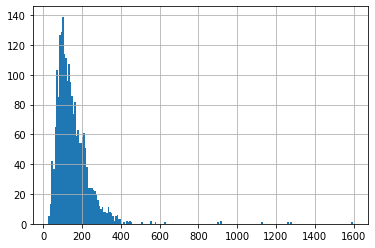

In [35]:
data['processed_lenght'] = data.processed.apply(lambda l: len(l.split(' ')))
data['processed_lenght'].hist(bins=200)

In [31]:
doc_list = [d for d in data.text]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 933960. Unique words: 43772


In [38]:
doc_list = [d for d in data.processed]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 337280. Unique words: 14679


## TFIDF

In [6]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print(NUM_CLUSTERS)

5


In [8]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.9,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

## Moving to a Catalog Format

In [10]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [11]:
catalog = Catalog()
catalog.documents = documents

In [12]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 461)


,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.093,0.315,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


**We actually have already a vocab in our Model instance**

In [13]:
[ (k,v) for i,(k,v) in enumerate(tfidf.token2id.items()) if i<5 ]

[('tv', 436), ('future', 164), ('hand', 182), ('system', 414), ('high', 188)]

## Clustering

In [15]:
from sklearn.cluster import KMeans

def kmean_clustering(
    model, # class Model
    num_clusters:int=4,
    njobs=-1,
    random_state=46):
    '''
    TODO: Consider MiniBatchKMeans
    Args:
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for

    Returns: 
        - Clustering model instance
    '''
    km = KMeans(
        n_clusters=num_clusters,
        init='k-means++',
        n_init=20,
        max_iter=1000,
        n_jobs=njobs,
        random_state=random_state)
    return km.fit(model.representation)

In [16]:
def words_per_cluster(
    model,
    clusters:KMeans,
    words_per_cluster:int=None):
    '''
    Return the j most important words per cluster
        The k closest to the centroid of that cluster
        Equivalently: the words are the ones most present in the 'fake'
        document represented by the centroid of the cluster

    Args:
        - Clustering model instance
    
    Returns:
        - Dict key='cluster id', value=k_words_closest_to_centroid
    '''
    
    cluster_words = defaultdict(list)
    centroids = clusters.cluster_centers_
    
    # For each centroid
    for i,centroid in enumerate(centroids):
        # Bring K most similar words to centroid i
        closests_words_to_centroid = centroid.argsort()[::-1] 
        for idx in closests_words_to_centroid:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [17]:
clusters = kmean_clustering(model=tfidf, njobs=1, num_clusters=NUM_CLUSTERS)
BEST_WORDS_PER_CLUSTER = words_per_cluster(tfidf,clusters)

**Save Model**

In [39]:
name = 'kmeans_clustering_K_5.pkl'

In [18]:
with open(JP(paths['results'],name),'wb') as obj:
    pickle.dump(clusters, obj)

**Load Model**

In [40]:
with open(JP(paths['results'],name),'rb') as obj:
    clusters = pickle.load(obj)

#### How can be simmilar words the most important one for different clusters?

#### RECALL REAL DISTRIBUTION OF CATEGORIES

In [20]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


**Bad clustering?**

## Words per Cluster

In [21]:
centroids = pd.DataFrame(clusters.cluster_centers_,columns=tfidf_df.columns)
centroids.index = range(1,NUM_CLUSTERS+1)
centroids.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
1,0.010,0.002,0.000,0.003,0.002,0.003,0.003,0.014,0.031,0.019,...,0.036,0.017,0.109,0.016,0.014,0.019,0.041,0.003,0.042,0.010
2,0.006,0.005,0.001,0.011,0.003,0.004,0.021,0.013,0.015,0.003,...,0.018,0.020,0.087,0.047,0.021,0.029,0.020,0.025,0.068,0.016
3,0.005,0.006,0.005,0.019,0.018,0.008,0.005,0.011,0.021,0.004,...,0.018,0.003,0.005,0.002,0.001,0.013,0.021,0.003,0.076,0.001
4,0.014,0.008,0.020,0.016,0.008,0.007,0.015,0.014,0.022,0.006,...,0.019,0.003,0.012,0.002,0.018,0.035,0.023,0.015,0.044,0.009
5,0.012,0.009,0.004,0.006,0.004,0.020,0.011,0.013,0.027,0.004,...,0.025,0.006,0.022,0.001,0.013,0.027,0.011,0.010,0.031,0.008


#### Filter best N words of each cluster and M shared across clusters

In [22]:
def best_words(cluster_tfidf):
    best_words = defaultdict(float)
    for c in range(1,NUM_CLUSTERS+1):
        best_words[c] = cluster_tfidf.loc[c].\
            sort_values(ascending=False).index.to_list()
    return best_words

def best_common_words(best_words, N=10, verbose=1):
    words = set()
    for i in range(1,1+NUM_CLUSTERS):
        for word in best_words[i][:N]:
            words.add(word)
    if verbose>0:
        print('{} unique words after grouping the {} most important words of the {} clusters'\
              .format(len(words), N, NUM_CLUSTERS))
        print('{} words are shared'.format(N*NUM_CLUSTERS - len(words)))
        print('Some common words {}'.format(list(words)[:6]))
    return list(words)

N = 50
best_words = best_words(centroids)
best_words_in_common = best_common_words(best_words, N)

192 unique words after grouping the 50 most important words of the 5 clusters
58 words are shared
Some common words ['world', 'music', 'great', 'election', 'race', 'place']


---

# Plotting the WordClouds


In [23]:
%matplotlib inline
from wordcloud import WordCloud

#### Helper Functions for Plotting

In [29]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)

In [30]:
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud


In [31]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c+1],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return


### Data to desired format

In [32]:
scores = pd.melt(centroids.rename_axis('cluster').reset_index(), 
                 id_vars=['cluster'], var_name='word', value_name='score')

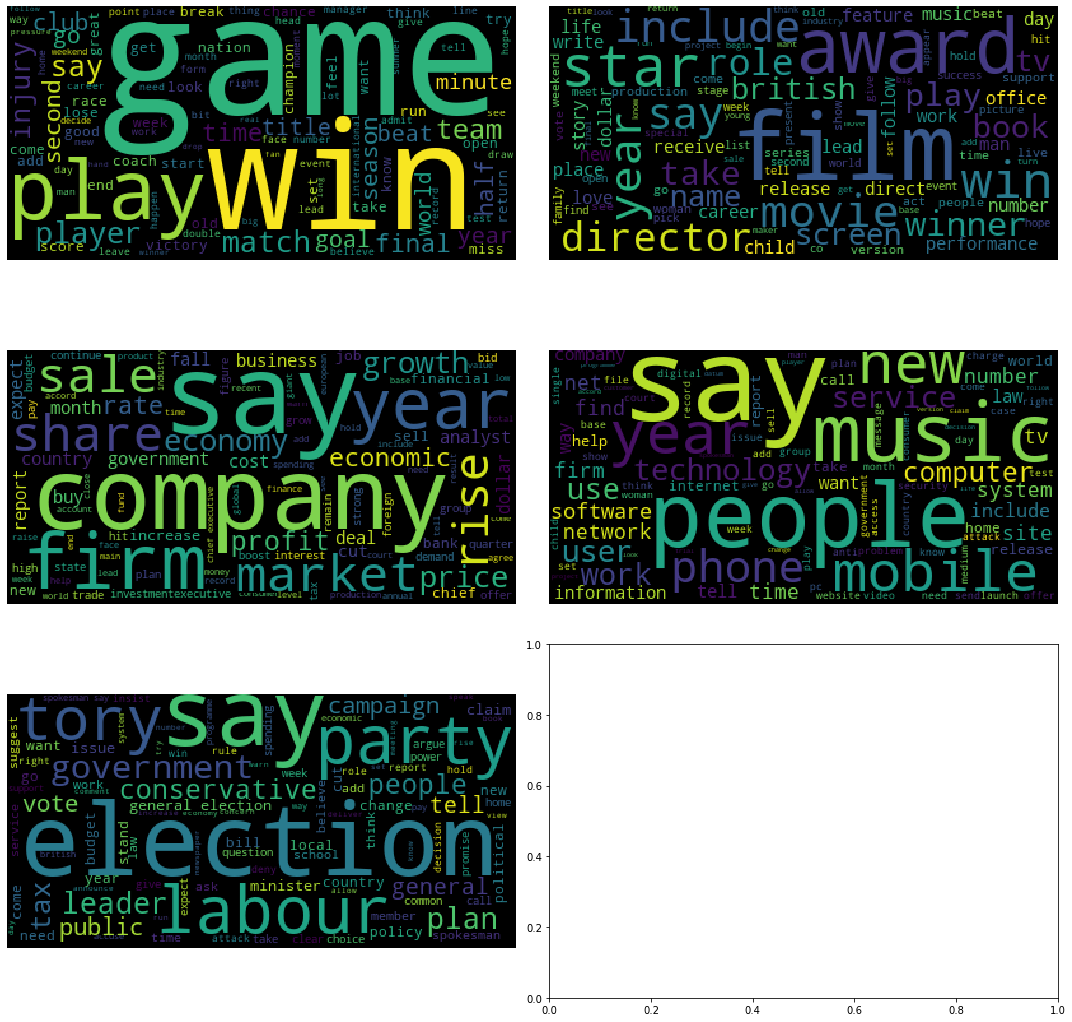

In [33]:
plot_centroids_as_wordclouds(scores, n_cols=2)

# Validation

**According to importants words of cluster lets assigned a classification:**

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [98]:
cluster_preds = ['sport', 'entertainment', 'business', 'tech', 'politics']  
d = dict(zip(range(NUM_CLUSTERS), cluster_preds))
d

{0: 'sport', 1: 'entertainment', 2: 'business', 3: 'tech', 4: 'politics'}

In [99]:
data['predict'] = [d[i] for i in clusters.labels_]

In [100]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [138]:
print(data.predict.value_counts())

tech             767
sport            510
business         481
politics         256
entertainment    211
Name: predict, dtype: int64


In [145]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

,sport,entertainment,business,tech,politics
sport,454,4,1,52,0
entertainment,8,197,11,170,0
business,1,0,447,56,6
tech,44,10,7,339,1
politics,3,0,15,150,249
